# Access GEDI L4B Dataset with OGC Web Services

This tutorial will demonstrate how to visualize and access [Global Ecosystem Dynamics Investigation (GEDI) L4B Gridded Aboveground Biomass Density (AGBD) dataset](https://doi.org/10.3334/ORNLDAAC/2017) using the [Open Geospatial Consortium (OGC)](http://www.opengeospatial.org/) web services. The OGC web services offer a simple HTTP interface for requesting access, visualization, and processing of geospatial datasets. GEDI L4B dataset is available in ORNL DAAC's [Spatial Data Access Tools (SDAT)](https://webmap.ornl.gov/ogc/dataset.jsp?ds_id=2017), which offers OGC-based web services to visualize and download spatial data in various user-selected spatial/temporal extents and formats. For GEDI L4B, which is a gridded dataset, two different requests are currently supported: (1) [web map service (WMS)](https://www.ogc.org/standards/wms/introduction) to request map images for visualization of geospatial data from a remote server, (2) [web coverage service (WCS)](https://www.ogc.org/standards/wcs) to download geospatial data from a remote server.

For this tutorial, we will first visualize the GEDI L4B dataset over Australia using the OGC WMS service and then access the dataset using the OGC WCS service to compute summaries of AGBD for six states and two territories of Australia.

This tutorial requires the following Python modules installed in your system: `folium`, `owslib`, `pandas`, `geopandas`, `requests`, `rasterio`, `rasterstats`, `matplotlib`, . Requirements are also in [requirements.txt](requirements.txt). To install the necessary Python modules, you can copy the requirements.txt from this repository and run:
```bash
pip install -r requirements.txt
```

In [1]:
# import python modules
%matplotlib inline
%config IPCompleter.greedy=True
import folium
import owslib.wcs as wcs
import owslib.wms as wms
import pandas as pd
import requests as re
import matplotlib.pyplot as plt
from folium.plugins import FloatImage
from rasterstats import zonal_stats
from rasterio.plot import show
import datetime as dt 
from shapely.geometry import Polygon
import pygc
from tqdm import tqdm
import rasterio as rio
import numpy as np
from geojson import Feature, FeatureCollection, dump
import os
import geopandas as gpd

Let's read and plot the GeoJSON file with the states and territories of Australia.

In [2]:
# variables for data search

# coordinates file path
main_datafile_path = "./csvfiles/estingAustralia.csv"

# lengths in m
ew_width = 2000
ns_height = 2000
size = int(ew_width/1000)

In [3]:
# loading coordinates file
treecoords = pd.read_csv(main_datafile_path)
treecoords

,Unnamed: 0,project,site,lat,long,Granule Number
0,0,SouthWestForests-DON019FireInv,k_1,-34.7310,116.2081,2
1,1,SouthWestForests-DON019FireInv,k_2,-34.7265,116.2081,2
2,2,SouthWestForests-DON019FireInv,k_3,-34.6949,116.2085,2
3,3,SouthWestForests-DON019FireInv,k_4,-34.7265,116.2136,1
4,4,SouthWestForests-DON019FireInv,k_5,-34.7221,116.2136,1
...,...,...,...,...,...,...
241,318,LIRE,k_242,-41.3530,147.5222,1
242,319,Ausplot Forest Monitoring Network,k_243,-41.3671,147.6032,3
243,320,LIPL,k_244,-42.4391,147.7789,3
244,321,LIPL,k_245,-42.7232,147.8451,5


In [5]:
test = treecoords.loc[0:0]
test

,Unnamed: 0,project,site,lat,long,Granule Number
0,0,SouthWestForests-DON019FireInv,k_1,-34.731,116.2081,2


In [4]:
# function to obtain bounding box from coordinate
def latLonBoxByWandH(lat,lon,ew_width,ns_height):
    lats, lons = [], []
    #distance in m, az (in deg), lat (in deg), long (in deg)

    res = pygc.great_circle(distance=ew_width/2, azimuth=90, latitude=lat, longitude=lon)
    lat, lon = res['latitude'], res['longitude']

    res = pygc.great_circle(distance=ns_height/2, azimuth=180, latitude=lat, longitude=lon)
    lat, lon = res['latitude'], res['longitude']
    lats.append(lat), lons.append(lon)

    res = pygc.great_circle(distance=ew_width, azimuth=270, latitude=lat, longitude=lon)
    lat, lon = res['latitude'], res['longitude']
    lats.append(lat), lons.append(lon)

    res = pygc.great_circle(distance=ns_height, azimuth=0, latitude=lat, longitude=lon)
    lat, lon = res['latitude'], res['longitude']
    lats.append(lat), lons.append(lon)

    res = pygc.great_circle(distance=ew_width, azimuth=90, latitude=lat, longitude=lon)
    lat, lon = res['latitude'], res['longitude']
    lats.append(lat), lons.append(lon)
    
    return {'lats':lats,'lons':lons}

In [7]:
# sitelist = treecoords['site']
# lat = list(treecoords['lat'])
# lon = list(treecoords['long'])
# projectlist = list(treecoords["project"])

sitelist = test['site']
lat = list(test['lat'])
lon = list(test['long'])
projectlist = list(test["project"])

In [8]:
#loc_lon,loc_lat
loc_lat = np.asfarray(lat,float)
loc_lon = np.asfarray(lon,float)
len(loc_lat),len(loc_lon)

(1, 1)

In [9]:

features = []
for lat, lon, code in tqdm(zip(loc_lat,loc_lon, sitelist), total = len(loc_lat)):
    box = latLonBoxByWandH(lat,lon,ew_width,ns_height)
    
    polygon_geom = Polygon(zip(box['lons'], box['lats']))
    features.append(Feature(geometry=polygon_geom, properties={"STE_CODE": code, "STE_NAME": code}))
    
feature_collection = FeatureCollection(features)
with open('myfile.geojson', 'w') as f:
    dump(feature_collection, f)

100%|██████████| 1/1 [00:00<00:00, 164.56it/s]


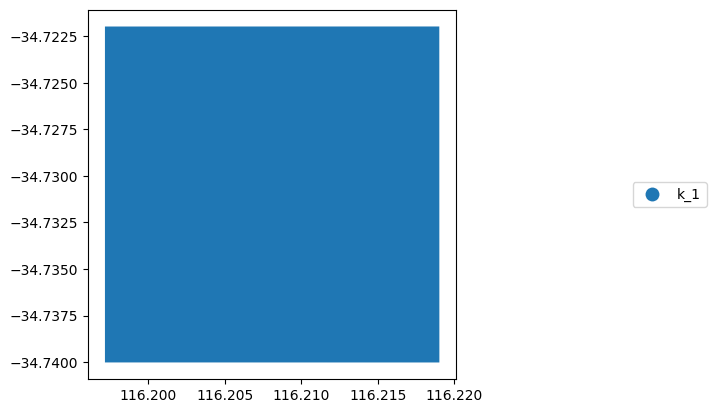

In [10]:
aus = gpd.read_file("myfile.geojson") 
ax = aus.plot(column="STE_NAME", legend=True, legend_kwds={'bbox_to_anchor':(1.7, .5), 'loc': 'right'})

## Access data with Web Coverage Service (WCS)
Let's retrieve the ORNL's WCS capabilities document. The capabilities document provides operations and services offered by the WCS Server. We will first retrieve the data for the Australia bounding box and then compute summaries for the states and territories.

In [11]:
ornl_wcs_url = "https://webmap.ornl.gov/ogcbroker/wcs"
ornl_wcs = wcs.WebCoverageService(ornl_wcs_url)
print(f'{ornl_wcs.identification.title} currently provides {len(ornl_wcs.contents)} WCS layers.')

ORNL DAAC WCS Server currently provides 20815 WCS layers.


The ORNL DAAC WCS Server has the following three capabilities. 

In [12]:
for i, op in enumerate(ornl_wcs.operations):
    print(f'{i+1}. {op.name}')

1. GetCapabilities
2. DescribeCoverage
3. GetCoverage


`DescribeCoverage` provides information about the layers' spatial extent, CRS, metadata, and formats. `GetCoverage` retrieves the actual spatial data or its subset based on spatio-temporal parameters. We will use `GetCoverage` capability to request GEDI L4B layers.

Now, let's print information about the GEDI L4B mean AGBD WCS layer (`2017_1`).

In [13]:
layer_wcs = ornl_wcs['2017_1']
wcs_meta = f'''Layer title : {layer_wcs.title}
Supported CRS : {layer_wcs.supportedCRS}
Bounding Box : {layer_wcs.boundingboxes}
Formats : {layer_wcs.supportedFormats}
Grid upper limits : {layer_wcs.grid.highlimits}'''
print(wcs_meta)

Layer title : GEDI L4B Gridded Mean Aboveground Biomass Density (AGBD), Version 2, Mission Weeks 19-138
Supported CRS : [urn:ogc:def:crs:EPSG::6933, urn:ogc:def:crs:EPSG::4326, urn:ogc:def:crs:EPSG::3785, urn:ogc:def:crs:EPSG::54004, urn:ogc:def:crs:EPSG::54008, urn:ogc:def:crs:EPSG::54009, urn:ogc:def:crs:EPSG::900913, urn:ogc:def:crs:EPSG::6933]
Bounding Box : [{'nativeSrs': 'EPSG:4326', 'bbox': (-179.999999998328, -85.0445664397416, 179.999999998328, 85.0445664397416)}, {'nativeSrs': 'epsg:6933', 'bbox': (-17367530.445, -7314540.831, 17367530.445, 7314540.831)}]
Formats : ['AAIGrid_FLOAT32', 'GeoTIFF_FLOAT32', 'HFA_FLOAT32', 'netCDF_FLOAT32', 'NITF_FLOAT32']
Grid upper limits : ['34703', '14615']


The GEDI L4B grids natively use a [global 1km EASEGrid 2.0 (epsg:6933)](https://nsidc.org/ease/ease-grid-projection-gt). Its grid size is `1000.895023349667440 meters`. Using the bounding box and horizontal and vertical grid sizes, let's compute the bounding box of Australia that aligns with the 1km EASEGRID.

In [14]:
# GEDI bbox in EPSG:6933 (EASEGrid2.0)
b2 = layer_wcs.boundingboxes[1]['bbox']
# GEDI number of grids across x and y
h = int(layer_wcs.grid.highlimits[0]) + 1
v = int(layer_wcs.grid.highlimits[1]) + 1
# GEDI grid size
res_xy = 1000.895023349667440
# create cell coordinates
x = np.linspace(b2[0]+res_xy, b2[2], num=h)
y = np.linspace(b2[3]-res_xy, b2[1], num=v)
# convert australia polygon geopandas to EASEGRID 2
aus_ease = aus.to_crs('EPSG:6933')
# compute min, max bounds
xmin, ymin, xmax, ymax = aus_ease.total_bounds 
# find the min, max bounds that aligns with
# EASEGRID cell coordinates
xmin = x[np.abs(x - xmin).argmin()]
ymin = y[np.abs(y - ymin).argmin()]
xmax = x[(np.abs(x - xmin).argmin())+2]
ymax = y[(np.abs(y - ymin).argmin())-2]


In [15]:
print(xmin, ymin, xmax, ymax)

11211025.156434134 -4171730.4575270843 11213026.946480814 -4169728.667480286


The "quality flag" layer (identifier=`2017_4`) provides information as to if the land grid meets the GEDI L1A mission  requirement (percent standard error <20% or standard error < 20 Mg ha-1), indicated by a grid value of 2. For this tutorial, we will compute summaries of the AGBD estimates where GEDI L1 mission requirements are met.

We will use WCS's `getCoverage` capability to request two layers (mean AGBD and quality flag) in a GeoTIFF format for the Australia bounds. We will also ensure the CRS parameter is set to the native `EPSG:6933`.

In [16]:
# mean AGBD and quality flag layers
layers = ['2017_1', '2017_4']

# loop over layers
for lyr in layers:
    # WCS request
    cov = ornl_wcs.getCoverage(identifier=lyr,
                               bbox=(xmin, ymin, xmax, ymax),
                               crs='EPSG:6933',
                               format='GeoTIFF_FLOAT32',
                               resx=res_xy, resy=res_xy)
    # save the results to GeoTIFFs
    otif = f"{lyr}.tif"
    print(f"writing {otif}")
    with open(otif, 'wb') as f:
        f.write(cov.read())

writing 2017_1.tif
writing 2017_4.tif


Let's read the band data and transformation and nodata information of the above GeoTIFF. We will also plot the images.

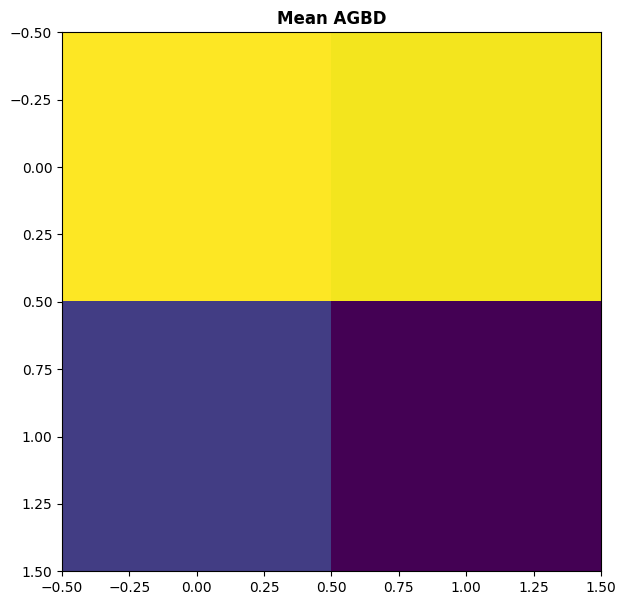

In [7]:
# read mean AGBD layer
with rio.open('./clipped_gedi/k_2_2017_1.tif', 'r') as src:
    affine = src.transform
    nodata = src.nodata
    l4a_agbd = src.read(1)

# read quality flag layer
# with rio.open('2017_4.tif', 'r') as src:
#     nodata2 = src.nodata
#     l4a_qa = src.read(1)

# plot images
fig, (ax_agbd) = plt.subplots(1, figsize=(7, 7))
show(l4a_agbd, ax=ax_agbd, title='Mean AGBD')
# show(l4a_qa, ax=ax_qa, title='Quality Flag')
plt.show()

In [8]:
l4a_agbd

array([[348.3905 , 343.98135],
       [158.06517, 116.32609]], dtype=float32)

We have AGBD values saved in the array `l4a_agbd` and quality flags saved in the array `l4a_qa`. We can use these to compute basic AGBD statistics for the states/territories of Australia.

In [114]:
# assign nodata to grids with QA value != 2 
l4a_agbd[l4a_qa!=2] = nodata
# assign nodata to grids with QA value != 1
l4a_qa[l4a_qa!=1] = nodata2

# compute grid size in hectares
grid_ha = (res_xy * res_xy) / 10000
# create a new column to store state area in hectare
aus_ease['area_ha'] = aus_ease['geometry'].area / 10000

# loop through each states
for j in aus_ease.index:
    # compute AGBD statistics for each state
    stats1 = zonal_stats(vectors=aus_ease.iloc[j].geometry, raster=l4a_agbd, affine=affine, nodata=nodata,
                                 stats=['sum', 'mean', 'count'])
    aus_ease.at[j, 'agb_total'] = stats1[0]['sum']
    aus_ease.at[j, 'count_good'] = stats1[0]['count']
    
    # compute total land count (l4a_qa == [1,2])
    stats2 = zonal_stats(vectors=aus_ease.iloc[j].geometry, raster=l4a_qa, affine=affine, nodata=nodata2,
                                 stats=['count'])
    aus_ease.at[j, 'count_land'] = stats1[0]['count'] + stats2[0]['count']

# percent grids meeting L1 requirement
aus_ease['percent_good_grids']= (aus_ease['count_good'] / aus_ease['count_land']) *100
# total AGB in Mg
aus_ease['agb_total_Mg']= aus_ease['agb_total'] * aus_ease['count_good'] * grid_ha
# Mean AGB for states
aus_ease['agbd_mean']= aus_ease['agb_total_Mg'] / aus_ease['area_ha']
# printing the statistics
aus_ease[['STE_NAME', 'area_ha', 'percent_good_grids', 'agb_total_Mg', 'agbd_mean']]

,STE_NAME,area_ha,percent_good_grids,agb_total_Mg,agbd_mean
0,k_4,400.042397,25.0,4727.117636,11.816542


In the above table, `area_ha` is the area of the state/territory in hectares; `percent_good_grids` is the percentage of the GEDI L4B grids that meets GEDI L1 mission requirement (percent standard error <20% or standard error < 20 Mg ha-1); `agb_total_Mg` is the total aboveground biomass in Mg for all grids that meets L1 mission requirement; and `agbd_mean` is mean AGBD for the state/territory in Mg ha-1.

## Getting GEDI L4B data into a GIS
Some of us may want to bring the GEDI layers into desktop Geographic Information System (GIS) clients for further analysis. Most of the modern GIS software has capabilities to support OGC web services. 
- [ESRI's ArcGIS software](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) suite also supports these capabilities - refer to [this documentation](https://pro.arcgis.com/en/pro-app/latest/help/data/services/ogc-services.htm) on how to load OGC web services into ESRI software. 
- [QGIS](https://qgis.org) is a freely available open-source desktop GIS software and supports OGC capabilities. Please refer to [this documentation](https://docs.qgis.org/3.22/en/docs/user_manual/working_with_ogc/ogc_client_support.html) for further help. 

The OGC [WMS/WCS capabilities](https://webmap.ornl.gov/ogc/dataset.jsp?ds_id=1952) are also available for the [GEDI L3 dataset](https://doi.org/10.3334/ORNLDAAC/1952), which provides gridded land surface and canopy metrics. 

